# EXCEED Python Qualtrics Survey - Detailed Analysis

This notebook provides a detailed analysis of the EXCEED Python Qualtrics survey data. It includes data loading, cleaning, and various analyses to understand the survey responses better. The ultimate goal of this analysis is to find the best subset of questions that can best differentiate between Python _beginner_/_novice_ and _advanced_/_expert_ users.

The Qualtrics survey is composed of the following blocks, where each participant is required to answer all questions in each block. Note that for blocks 3 to 8, each respondent is given a random subset of 2 out of the 7 available questions, hence the total number of survey-related questions per-participant is always 16 (i.e., 8 blocks of 2 questions each). The question blocks in the entire survey are as follows:
1. **Consent Form**: Participants agree to take part in the survey. If they do not agree, they are redirected to the end of the survey.
2. **Self-assessment**:
    1. **Python Experience**: Participants self-assess their Python experience using [Dreyfus levels](https://en.wikipedia.org/wiki/Dreyfus_model_of_skill_acquisition).
    2. **Python Programming YoE**: Participants indicate their years of experience with Python programming.
    3. **General Programming YoE**: Participants indicate their years of experience with programming in general.
3. **General Programming Error Understanding**: 7 questions
4. **Python-Specific General Error Understanding**: 7 questions
5. **Code Reading / Understanding**: 7 questions
6. **Error Message Comprehension**: 7 questions
7. **Error Resolution**: 7 questions
8. **Error Message Comprehension**: 7 questions
9. **Natural Language Scenarios**: 7 questions
10. **Miscellanous Questions - Various Complexity & Scope**: 7 questions
11. **Self-Assessment of Results**: Participants self-assess the number of questions they answered correctly in the survey (0 to 16).

## Step 0.1: Install Required Libraries

Prior to running the analysis, ensure that the required libraries are installed. For this, you need only install the libraries defined in the `requirements.txt` file. You can do this by running the following command in your terminal:

```bash
pip install -r requirements.txt
```

In [2]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 0.2: Load the data

For this step, we need to load 2 CSV files:
1. `survey_results_<date>.csv`: Contains the survey responses and some other metadata (the `<date>` part is meant to be replaced with the actual date of the survey, e.g., `survey_results_02_06_2025.csv`).
2. `survey_answers.csv`: Contains the correct answers for the survey questions

In [3]:
import pandas as pd

file_path_survey_results = "../data/survey_results_02_06_2025.csv"
file_path_survey_answers = "../data/survey_answers.csv"

# Step 0. Load data (files are semicolon‑delimited)
df_results = pd.read_csv(file_path_survey_results, sep=';')
df_answers = pd.read_csv(file_path_survey_answers, sep=';')

## Step 1: Build Answers DataFrame

To calculate the accuracy of the answers, we need to build a DataFrame that contains the correct answers for each question. This DataFrame will be used to compare the participants' responses against the correct answers. This step will create a dictionary that maps each question ID to its correct answer, and then build a list of question columns that are present in the results DataFrame. Note that since we are talking about "correct question answers", this means that we are referring to the questions in blocks 3 to 10 inclusive.

In [4]:
# Always treat answers as strings (since all are whole numbers between 1 and 4)
answer_key = {}
for qid, ans in zip(df_answers["QuestionId"], df_answers["CorrectAnswer"]):
    answer_key[qid] = [str(int(a.strip())) for a in str(ans).split(",")]

# 1. Build columns for each question
question_cols = [q for q in answer_key if q in df_results.columns]

## Step 2: Mark Questions as Correct or Incorrect

To determine whether a participant answered a question correctly, we will compare their response to the correct answer. We will create a new DataFrame that contains the correctness of each answer (True for correct, False for incorrect). Note that because some questions were too ambiguous, there are 2 questions where there are 2 correct answers, and therefore we will treat either of the answers as correct.

In [5]:
# Create a new DataFrame with the correct answers (supporting multiple correct answers)
def is_correct(row):
    return pd.Series({
        q: str(int(row[q])) in answer_key[q] if pd.notna(row[q]) else False
        for q in question_cols
    })


correct_df = df_results.apply(is_correct, axis=1)
df_results["total_correct"] = correct_df.sum(axis=1)

## Step 3: Compute Accuracy for Each Question

Compute the accuracy for each question by calculating the percentage of correct answers among all participants who answered that question. This will help us identify which questions are more effective in differentiating between beginner/novice and advanced/expert users. This step will create a DataFrame that contains the percentage of correct answers for each question, sorts them in descending order of correctness, and displays the results in a readable format.

> Note: You will notice that question accuracy and question difficulty are used interchangeably throughout this notebook - this is indeed the case.

In [6]:
# Boolean mask: True if answered AND correct, NaN if unanswered (supporting multiple correct answers)
def check_correct(row):
    result_dict = {}
    for q in question_cols:
        val = row[q]
        if pd.isna(val):
            result_dict[q] = float('nan')
        else:
            result_dict[q] = str(int(val)) in answer_key[q]
    return pd.Series(result_dict)


correct_mask = df_results.apply(check_correct, axis=1)
correct_mask = correct_mask.astype("float")

# Per-question counts
correct_cnt = correct_mask.sum()
answered_cnt = df_results[question_cols].notna().sum()

# Calculate the percentage of correct answers for each question
perc_correct = (correct_cnt / answered_cnt * 100).round(1).rename("% correct")

# Create a DataFrame with the percentage of correct answers
question_perf = (
    perc_correct.reset_index()
    .rename(columns={"index": "Question"})
    .sort_values("% correct", ascending=False)
    .reset_index(drop=True)
)

# Display the question performance DataFrame
from IPython.display import display, HTML

display(HTML("<h2>Question Performance / Difficulty</h2>"))
display(question_perf)

# Save the question performance DataFrame to a CSV file for further analysis
from pathlib import Path

out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)
question_perf.to_csv(out_dir / "question_performance.csv", index=False)

,Question,% correct
0,Q8.7,100.0
1,Q7.4,100.0
2,Q10.6,100.0
3,Q10.4,100.0
4,Q3.5,100.0
5,Q7.5,100.0
6,Q6.3,100.0
7,Q4.1,100.0
8,Q8.3,100.0
9,Q6.1,100.0


## Step 4: Calculate Question (i.e., item) Difficulty and Discrimination

We will attempt to find the top 2 "_best_" questions from each block based on their accuracy. The criteria for "_best_" is a combination of item difficulty and item discrimination, which can be calculated using the following metrics:

1. **Item Difficulty**: The percentage of correct answers for a given question (already calculated in the previous step).
2. **Item Discrimination**: The correlation with a respondent's overall ability.

This is a pre-requisite for actually finding the best subset of questions, which will be done in the next step. Additionally, this step will also skip any items that have fewer than 10 valid answers (i.e., completed) to avoid unstable discrimination index calculations. To the best of our knowledge, such questions do not exist in the current dataset, but this is a good practice to follow in general.

> Note: When running the code below, you may see some warnings similar to `ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.` - this is expected, and can be ignored. It simply means that the question was answered the same way by all respondents, so there is no variability to compute a correlation.

In [7]:
from scipy.stats import pointbiserialr

# Total score per respondent (all questions from block 3 to block 10 inclusive); NaN treated as 0
df_results["total_score"] = correct_mask.fillna(0).sum(axis=1)

# Compute p (proportion correct) and r_pb (discrimination index)
records = []

for q in correct_mask.columns:
    # Boolean / NaN vector for this item
    item = correct_mask[q]

    # Skip items with < 10 valid answers to avoid unstable r
    if item.notna().sum() < 10:
        continue

    # Difficulty p
    p = item.mean(skipna=True)

    # Rest-of-test score (subtract the item itself if answered)
    rest = df_results["total_score"] - item.fillna(0)

    # Point-biserial correlation (returns r, p-value)
    r_pb, p_value = pointbiserialr(item.dropna(), rest.loc[item.notna()])

    block = q.split(".")[0]
    records.append(
        {
            "block": block,
            "question": q,
            "difficulty": p,
            "r_pb": r_pb,
            "p_value": p_value
        }
    )

# Create a DataFrame with the calculated statistics
stats_df = pd.DataFrame(records)

# Save the statistics DataFrame to a CSV file for further analysis
stats_df.to_csv(out_dir / "item_stats.csv", index=False)

/Users/amoraru/Documents/GitHub/EXCEED/exceed-python-skill-assessment/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


## Step 5: Filter Questions for Acceptable Difficulty Range & Display All Items

This step filters the questions based on the acceptable difficulty range (0.25 <= p <= 0.85) and displays all items ranked by their discrimination index (r_pb). This will help us understand which questions are more effective in differentiating between beginner/novice and advanced/expert users. In terms of output, this step does the following:
- Displays the number of survey questions considered before filtering for acceptable difficulty range. This number should be 56, since there are 7 questions in each of the 8 blocks (3 to 10).
- Displays the number of survey questions considered after filtering for acceptable difficulty range.

> Note: This is still not the final subset of questions, but rather a preliminary step to identify the best questions based on their difficulty and discrimination index. On top of that, we will also vary the actual difficulty range in follow-up steps to find the best subset of questions that can differentiate between beginner/novice and advanced/expert users.

In [8]:
# Keep items in an acceptable difficulty range (0.25 <= p <= 0.85) - note that we will vary this range later as well
print("Number of survey questions considered before filtering for acceptable difficulty range:", len(stats_df))
filtered_stats_df = stats_df.query("0.25 <= difficulty <= 0.85").copy()
print("Number of survey questions considered after filtering for acceptable difficulty range:", len(filtered_stats_df))

# Add a numeric block column
filtered_stats_df["block_num"] = filtered_stats_df["block"].str.slice(1).astype(int)

# Rank by discrimination index (r_pb) and take the top 2 per block
filtered_stats_df = (
    filtered_stats_df.sort_values(["block_num", "r_pb"], ascending=[True, False])
    .assign(rank=lambda d: d.groupby("block_num").cumcount() + 1)
)

# Display all the items ranked by discrimination
display(HTML("<h2>Item Statistics (after filtering for acceptable difficulty range)</h2>"))
display(filtered_stats_df[["block", "question", "difficulty", "r_pb", "p_value"]]
        .style.format({"difficulty": "{:.2f}", "r_pb": "{:.2f}"}))

Number of survey questions considered before filtering for acceptable difficulty range: 56
Number of survey questions considered after filtering for acceptable difficulty range: 23


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
6,Q3,Q3.7,0.84,-0.02,0.942969
2,Q3,Q3.3,0.56,-0.15,0.551836
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
13,Q4,Q4.7,0.56,0.16,0.525662
15,Q5,Q5.2,0.83,0.65,0.003509
20,Q5,Q5.7,0.65,0.18,0.485341
18,Q5,Q5.5,0.72,0.17,0.509281
25,Q6,Q6.5,0.84,0.60,0.006316


## Step 6: Find Best Subset of Questions (2 per Block)

This block will display the top 2 questions per block based on their discrimination index, i.e., how well they differentiate between beginner/novice and advanced/expert users.

### Discrimination Index (r_pb)

The discrimination index (r_pb) is calculated using the point-biserial correlation coefficient, which measures the relationship between a binary variable (correct/incorrect) and a continuous variable (total score excluding the item itself). The following ranges for **r_pb** are as follows:
- **0.00 - 0.19/0.2**: Weak discriminator / Should be replaced
- **0.20 - 0.29**: Acceptable discriminator
- **>= 0.30**: Strong discriminator

In [9]:
# Create a DataFrame with the top 2 questions per block based on discrimination index
top2_df = (
    filtered_stats_df[filtered_stats_df["rank"] <= 2]
    .sort_values(["block_num", "r_pb"], ascending=[True, False])
)

# Display the top 2 items per block
display(HTML("<h2>Top 2 Chosen Questions per Block Using Difficulty Range 0.25-0.85</h2>"))
display(top2_df[["block", "question", "difficulty", "r_pb", "p_value"]]
        .style.format({"difficulty": "{:.2f}", "r_pb": "{:.2f}"}))

# Save the top 2 questions per block to a CSV file for further analysis
top2_df.to_csv(out_dir / "top2_items.csv", index=False)

,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
6,Q3,Q3.7,0.84,-0.02,0.942969
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
15,Q5,Q5.2,0.83,0.65,0.003509
20,Q5,Q5.7,0.65,0.18,0.485341
25,Q6,Q6.5,0.84,0.60,0.006316
22,Q6,Q6.2,0.65,0.35,0.164594
29,Q7,Q7.2,0.56,0.51,0.045984
30,Q7,Q7.3,0.76,0.44,0.080006


## Step 7: Compute Average Correct Overall

Compute the average number of correct answers across all participants. This will give us an overall sense of how well participants performed on the survey.

In [10]:
avg_total_correct = df_results["total_correct"].mean()

# Display the average number of correct answers
print("Average number of correct answers across all participants: {:.2f}".format(avg_total_correct))

Average number of correct answers across all participants: 10.78


## Step 7.1: Compute Average Correct Answers Overall Per Skill Level

We would also like to compute the average number of correct answers for each skill level, as self-reported by the participants in both Q2.1 and Q2.2. This will help us understand how well participants performed based on their self-assessed skill level. We would like to experiment with the threshold at which we consider a participant to be a beginner/novice or advanced/expert user. The default threshold is set to 3, meaning that if a participant self-reports their skill level as 1, 2, or 3, they are considered a beginner/novice user, and anything above that is considered an advanced/expert user. Note, however, that Python YoE do not necessarily mean that the participant is a beginner or expert user. Before we do this, we need to have some function that will make it easier to experiment with different skill-level thresholds.

In [11]:
# Write a function that is provided with a DataFrame and a threshold for Python YoE, and returns the average number of correct answers for each skill level,
# where skill level is defined as either beginner/novice (when Python YoE is below the threshold) or advanced/expert (when Python YoE is above the threshold).
def compute_avg_correct_by_skill_level(df, skill_level_threshold=3):
    """
    Compute the average number of correct answers by skill level based on Python YoE.

    Args:
        df: DataFrame containing survey results.
        skill_level_threshold: Threshold for Python YoE to differentiate between beginner/novice and advanced/expert users.

    Returns:
        DataFrame with average correct answers by skill level.
    """
    # Define skill levels based on Python YoE
    df["skill_level"] = df["Q2.2"].apply(
        lambda x: "Beginner/Novice" if x < skill_level_threshold else "Advanced/Expert")

    # Compute average correct answers by skill level
    avg_correct_by_skill = df.groupby("skill_level")["total_correct"].mean().reset_index()

    return avg_correct_by_skill

## Step 7.2: Display Average Correct Answers by Skill Level (Experimenting with Threshold)

In [12]:
# Define different thresholds for Python YoE to experiment with
thresholds = [1, 2, 3, 4, 5]

# Collect average correct answers by skill level for different thresholds
avg_correct_thresholds = {}

# Display average correct answers by skill level for different thresholds
for threshold in thresholds:
    avg_correct = compute_avg_correct_by_skill_level(df_results, threshold)
    avg_correct_thresholds[threshold] = avg_correct
    display(HTML(f"<h4>Average Correct Answers by Skill Level (Python YoE Threshold: {threshold})</h4>"))
    display(avg_correct.style.format({"total_correct": "{:.2f}"}))

,skill_level,total_correct
0,Advanced/Expert,10.78


,skill_level,total_correct
0,Advanced/Expert,11.05
1,Beginner/Novice,9.46


,skill_level,total_correct
0,Advanced/Expert,11.24
1,Beginner/Novice,9.37


,skill_level,total_correct
0,Advanced/Expert,11.09
1,Beginner/Novice,10.08


,skill_level,total_correct
0,Advanced/Expert,11.02
1,Beginner/Novice,10.47


## Step 7.3: Visualize Average Correct Answers by Skill Level (By varying Threshold)

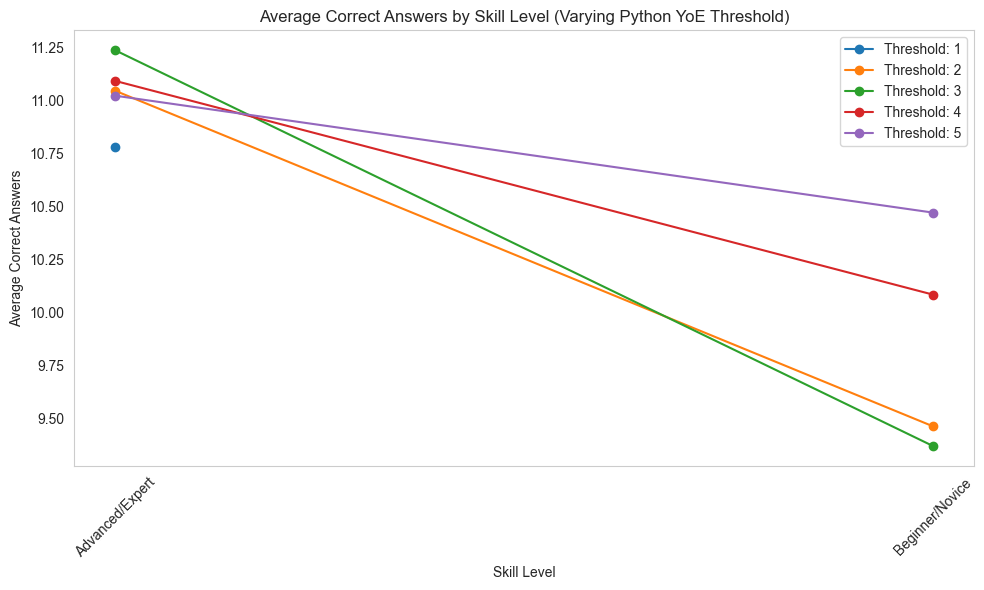

In [13]:
import matplotlib.pyplot as plt


# Plot average correct answers by skill level for different thresholds
def plot_avg_correct_by_skill_level(avg_correct_thresholds):
    """
    Plot average correct answers by skill level for different Python YoE thresholds.
    Args:
        avg_correct_thresholds: Dictionary containing average correct answers by skill level for different thresholds. The keys are the thresholds (i.e. Python YoE) and the values are DataFrames with columns ['skill_level', 'total_correct']. The skill levels are either 'Beginner/Novice' or 'Advanced/Expert'. The total_correct column contains the average number of correct answers for each skill level.
    """

    plt.figure(figsize=(10, 6))

    for threshold, avg_correct in avg_correct_thresholds.items():
        plt.plot(avg_correct["skill_level"], avg_correct["total_correct"], marker='o', label=f'Threshold: {threshold}')

    plt.xlabel('Skill Level')
    plt.ylabel('Average Correct Answers')
    plt.title('Average Correct Answers by Skill Level (Varying Python YoE Threshold)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# Actually plot the average correct answers by skill level for different thresholds
# Note: This does not really show us much, but hey...it's cool ;)
plot_avg_correct_by_skill_level(avg_correct_thresholds)

## Step 8: Compute Average Number of Correct Answers per Block

For each of the actual survey blocks that contain skill-level assessment questions, we will compute the average correctness of the answers. This will help us understand how well participants performed in each block, or in other words, how easy/difficult each block was for the participants. Unfortunately, since each participant was given a random subset of 2 questions from each block, the number will be [0, 2] for each block, therefore not really useful for the overall analysis.

In [14]:
block_avgs = {}
for blk in range(3, 11):
    blk_cols = [c for c in question_cols if c.startswith(f"Q{blk}.")]
    block_avgs[f"Q{blk}"] = correct_df[blk_cols].sum(axis=1).mean()

## Step 9: Build Result Summary DataFrame

This DataFrame will summarize the results of the analysis, including the average correctness for each question, the overall average correctness, and the average correctness by block. This will provide a comprehensive overview of the survey results.

In [19]:
import numpy as np
from scipy.stats import pearsonr, spearmanr


def corr_with_p(df, x, y, method='spearman', round_r=2, round_p=5):
    pair = df[[x, y]].dropna()
    if len(pair) < 3 or pair[x].nunique() < 2 or pair[y].nunique() < 2:
        return np.nan, np.nan, len(pair)
    if method == 'spearman':
        r, p = spearmanr(pair[x], pair[y])
    else:
        r, p = pearsonr(pair[x], pair[y])
    return round(r, round_r), round(p, round_p), len(pair)


# Collect rows for the summary report
rows = [
    ("Average correct answers (all blocks)", avg_total_correct),
]

# Block averages (Q3 to Q10)
rows.extend(
    [(f"Average correct answers - Block {blk}", val) for blk, val in block_avgs.items()]
)

# Compute correlations
# rows.extend([
#     ("Pearson Correlation: Python YoE with total correct", df_results[["Q2.2", "total_correct"]].corr().iloc[0, 1]),
#     ("Pearson Correlation: General YoE with total correct", df_results[["Q2.3", "total_correct"]].corr().iloc[0, 1]),
#     ("Spearman Correlation: Total correct answers with self-reported correct answers",
#      df_results["total_correct"].corr(df_results["Q11.1"], method="spearman"))
# ])

# Compute correlations
r, p, n = corr_with_p(df_results, 'Q2.2', 'total_correct', method='pearson')
rows.append(("Pearson Correlation: Python YoE with total correct", {"r": r, "p": p, "n": n}))
r, p, n = corr_with_p(df_results, 'Q2.3', 'total_correct', method='pearson')
rows.append(("Pearson Correlation: General YoE with total correct", {"r": r, "p": p, "n": n}))
r, p, n = corr_with_p(df_results, 'total_correct', 'Q11.1', method='spearman')
rows.append(("Spearman Correlation: Total correct answers with self-reported correct answers",
             {"r": r, "p": p, "n": n}))

## Step 10: Display Result Summary

Finally, we will display the result summary DataFrame, which contains the average correctness of answers for each block and the overall correctness, as well as some additional correlation metrics.

In [20]:
# Create a DataFrame for the summary report
summary_df = pd.DataFrame(rows, columns=["Metric", "Value"])

# Display the summary report
display(
    summary_df.style.set_caption("Qualtrics Python Skill Level Assessment - Correctness Metrics").format(precision=2))

,Metric,Value
0,Average correct answers (all blocks),10.78
1,Average correct answers - Block Q3,1.46
2,Average correct answers - Block Q4,1.35
3,Average correct answers - Block Q5,1.36
4,Average correct answers - Block Q6,1.31
5,Average correct answers - Block Q7,1.28
6,Average correct answers - Block Q8,1.46
7,Average correct answers - Block Q9,1.28
8,Average correct answers - Block Q10,1.28
9,Pearson Correlation: Python YoE with total correct,"{'r': np.float64(0.28), 'p': np.float64(0.01527), 'n': 73}"


## Step 11: Effect of Varying Difficulty Thresholds and Top-N Selection

Previously, we have identified the top 2 questions per block based on their difficulty and discrimination index. However, we also mentioned that the initial difficulty range was set to 0.25 <= p <= 0.85, and this range will be adjusted to see how it affects the final subset of questions.

Below we demonstrate how changing the difficulty thresholds and the number of top questions per block affects the final subset of discriminating questions. This allows for easy comparison and sensitivity analysis. Firstly, we will define a function to facilitate easier parameterization of the selection process, and then we will apply it with different settings to see how the results change.

> Note: While the initial idea was to select the top 2 questions per block, we also realize that 16 questions may be too many for a single assessment, therefore we will also explore the option of selecting only 1 question per block, resulting in just 8 questions in total.

In [21]:
def select_top_questions(statistics_df, min_p=0.25, max_p=0.85, top_n=2):
    """
    Filter questions by difficulty and then rank them by discrimination index (i.e., the r_pb value capturing the
    relationship between the binary correctness of the question and the continuous total score excluding that question).
    Args:
        statistics_df: DataFrame with columns ['block', 'question', 'p', 'r_pb']
        min_p: minimum difficulty (inclusive)
        max_p: maximum difficulty (inclusive)
        top_n: number of top questions per block to select
    Returns:
        DataFrame with top_n questions per block within the difficulty range, ranked by r_pb.
    """
    filtered = statistics_df.query(f"@min_p <= difficulty <= @max_p").copy()
    filtered["block_num"] = filtered["block"].str.slice(1).astype(int)
    filtered = (
        filtered.sort_values(["block_num", "r_pb"], ascending=[True, False])
        .assign(rank=lambda d: d.groupby("block_num").cumcount() + 1)
    )
    return filtered[filtered["rank"] <= top_n].sort_values(["block_num", "r_pb"], ascending=[True, False])

In [22]:
# Define different settings for varying difficulty thresholds and top-N selection
settings = [
    # For the "all questions" setting, setting the upper bound to 1.0 makes no sense,
    # since for those perfectly answered questions, there is no variability to compute a correlation.
    {"min_p": 0.01, "max_p": 0.99, "top_n": 7, "label": "All Questions (0.01-0.99, Top 7)"},
    {"min_p": 0.25, "max_p": 0.85, "top_n": 2, "label": "Default Range (0.25-0.85, Top 2)"},
    {"min_p": 0.25, "max_p": 0.85, "top_n": 1, "label": "Default Range (0.25-0.85, Top 1)"},
    {"min_p": 0.20, "max_p": 0.90, "top_n": 2, "label": "Wider Range (0.20-0.90, Top 2)"},
    {"min_p": 0.20, "max_p": 0.90, "top_n": 1, "label": "Wider Range (0.20-0.90, Top 1)"},
    {"min_p": 0.20, "max_p": 0.95, "top_n": 2, "label": "Widest Range (0.20-0.95, Top 2)"},
    {"min_p": 0.20, "max_p": 0.95, "top_n": 1, "label": "Widest Range (0.20-0.95, Top 1)"},
    {"min_p": 0.30, "max_p": 0.80, "top_n": 2, "label": "Narrower Range (0.30-0.75, Top 2)"},
    {"min_p": 0.30, "max_p": 0.80, "top_n": 1, "label": "Narrower Range (0.30-0.75, Top 1)"},
]

# Display top questions for different settings
for s in settings:
    result = select_top_questions(stats_df, min_p=s["min_p"], max_p=s["max_p"], top_n=s["top_n"])
    display(HTML(f"<h4>{s['label']}</h4>"))
    display(result[["block", "question", "difficulty", "r_pb", "p_value"]].style.format(
        {"difficulty": "{:.2f}", "r_pb": "{:.2f}"}))


,block,question,difficulty,r_pb,p_value
1,Q3,Q3.2,0.94,0.25,0.310767
3,Q3,Q3.4,0.78,0.06,0.821123
6,Q3,Q3.7,0.84,-0.02,0.942969
5,Q3,Q3.6,0.86,-0.13,0.580756
2,Q3,Q3.3,0.56,-0.15,0.551836
0,Q3,Q3.1,0.95,-0.15,0.513946
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
9,Q4,Q4.3,0.95,0.35,0.137014
13,Q4,Q4.7,0.56,0.16,0.525662


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
6,Q3,Q3.7,0.84,-0.02,0.942969
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
15,Q5,Q5.2,0.83,0.65,0.003509
20,Q5,Q5.7,0.65,0.18,0.485341
25,Q6,Q6.5,0.84,0.60,0.006316
22,Q6,Q6.2,0.65,0.35,0.164594
29,Q7,Q7.2,0.56,0.51,0.045984
30,Q7,Q7.3,0.76,0.44,0.080006


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
12,Q4,Q4.6,0.82,0.50,0.042240
15,Q5,Q5.2,0.83,0.65,0.003509
25,Q6,Q6.5,0.84,0.60,0.006316
29,Q7,Q7.2,0.56,0.51,0.045984
36,Q8,Q8.2,0.78,0.40,0.104409
46,Q9,Q9.5,0.76,0.30,0.246696
53,Q10,Q10.5,0.78,0.38,0.116939


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
6,Q3,Q3.7,0.84,-0.02,0.942969
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
15,Q5,Q5.2,0.83,0.65,0.003509
20,Q5,Q5.7,0.65,0.18,0.485341
25,Q6,Q6.5,0.84,0.60,0.006316
22,Q6,Q6.2,0.65,0.35,0.164594
28,Q7,Q7.1,0.88,0.81,0.000089
29,Q7,Q7.2,0.56,0.51,0.045984


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
12,Q4,Q4.6,0.82,0.50,0.042240
15,Q5,Q5.2,0.83,0.65,0.003509
25,Q6,Q6.5,0.84,0.60,0.006316
28,Q7,Q7.1,0.88,0.81,0.000089
36,Q8,Q8.2,0.78,0.40,0.104409
46,Q9,Q9.5,0.76,0.30,0.246696
49,Q10,Q10.1,0.87,0.45,0.089090


,block,question,difficulty,r_pb,p_value
1,Q3,Q3.2,0.94,0.25,0.310767
3,Q3,Q3.4,0.78,0.06,0.821123
12,Q4,Q4.6,0.82,0.50,0.042240
10,Q4,Q4.4,0.61,0.41,0.091687
15,Q5,Q5.2,0.83,0.65,0.003509
17,Q5,Q5.4,0.94,0.36,0.147600
25,Q6,Q6.5,0.84,0.60,0.006316
22,Q6,Q6.2,0.65,0.35,0.164594
28,Q7,Q7.1,0.88,0.81,0.000089
29,Q7,Q7.2,0.56,0.51,0.045984


,block,question,difficulty,r_pb,p_value
1,Q3,Q3.2,0.94,0.25,0.310767
12,Q4,Q4.6,0.82,0.50,0.042240
15,Q5,Q5.2,0.83,0.65,0.003509
25,Q6,Q6.5,0.84,0.60,0.006316
28,Q7,Q7.1,0.88,0.81,0.000089
35,Q8,Q8.1,0.94,0.52,0.031744
48,Q9,Q9.7,0.94,0.71,0.001437
49,Q10,Q10.1,0.87,0.45,0.089090


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
2,Q3,Q3.3,0.56,-0.15,0.551836
10,Q4,Q4.4,0.61,0.41,0.091687
13,Q4,Q4.7,0.56,0.16,0.525662
20,Q5,Q5.7,0.65,0.18,0.485341
18,Q5,Q5.5,0.72,0.17,0.509281
22,Q6,Q6.2,0.65,0.35,0.164594
27,Q6,Q6.7,0.41,0.12,0.633946
29,Q7,Q7.2,0.56,0.51,0.045984
30,Q7,Q7.3,0.76,0.44,0.080006


,block,question,difficulty,r_pb,p_value
3,Q3,Q3.4,0.78,0.06,0.821123
10,Q4,Q4.4,0.61,0.41,0.091687
20,Q5,Q5.7,0.65,0.18,0.485341
22,Q6,Q6.2,0.65,0.35,0.164594
29,Q7,Q7.2,0.56,0.51,0.045984
36,Q8,Q8.2,0.78,0.40,0.104409
46,Q9,Q9.5,0.76,0.30,0.246696
53,Q10,Q10.5,0.78,0.38,0.116939
